# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (UTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs): #data_uti_incdt, data_uti_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_uti_admitted',
            event_col='event_uti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_uti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_uti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

In [12]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [13]:
#process 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [14]:
##add variable season
#convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] 
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

In [15]:
#add variable time period
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [16]:
data_uti['date'].max()

'2023-02'

#### event and duration

In [17]:
#scenario 1
#not hosped (nothing happened)
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [18]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]

In [19]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [20]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30

#give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

In [21]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [22]:
#drop anybody with age less than 18 or 0!
data_uti = data_uti[~(data_uti['age'] < 18)] 
data_uti['age'][data_uti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

In [23]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking_status = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking_status": dict_smoking_status})

In [24]:
#drop rows with missing region
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
   data_uti = data_uti[data_uti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

#replace rows with missing smoking_status with 0
if ('smoking_status' in data_uti.columns) and (data_uti['smoking_status'].isnull().sum() > 0):
    data_uti['smoking_status'] = data_uti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    data_uti['imd'] = data_uti['imd'].fillna(0)

In [25]:
#missing values of bmi assign 5 and 0; categorise bmi
data_uti['bmi_cat'] = 5

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 30:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 25) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 30):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 18.5) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 25):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 18.5:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

In [26]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])
#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [27]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking_status = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking_status": dict_smoking_status})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})

In [28]:
data_uti.ethnicity.value_counts('NA')

white      0.600037
unknown    0.250504
asian      0.074918
other      0.074541
Name: ethnicity, dtype: float64

In [29]:
data_uti.smoking_status.value_counts('NA')

unknown         0.414466
smoker          0.390572
never_smoked    0.129738
ex_smoker       0.065225
Name: smoking_status, dtype: float64

In [30]:
data_uti.bmi_cat.value_counts('NA')

obese             0.518002
unknown           0.256019
overweight        0.113434
healthy_weight    0.079824
underweight       0.032720
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [31]:
#categorise CCI
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

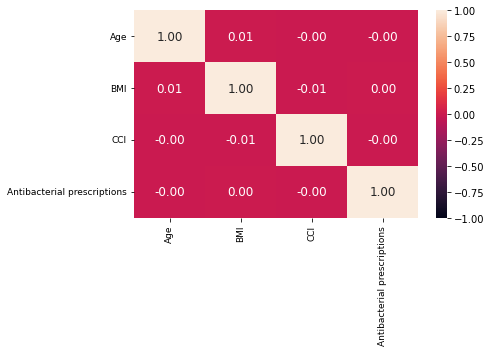

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [33]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                                   'event_uti_admitted', 'duration_uti_admitted'
                                    ]]

In [34]:
#switch variable uti_ab_date into a binary variable
data_uti[['ab_binary']] = data_uti[['uti_ab_date']].where(data_uti[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 1]

In [35]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['period'] == 'prepandemic']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['period'] == 'during_pandemic')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['period'] == 'post_2nd_lockdown']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['period'] == 'prepandemic']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['period'] == 'during_pandemic')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt_prepandemic = data_uti_incdt_prepandemic[data_uti_incdt_prepandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_during_pandemic = data_uti_incdt_during_pandemic[data_uti_incdt_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_post_2nd_lockdown = data_uti_incdt_post_2nd_lockdown[data_uti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_uti_no_abs_prevl_prepandemic = data_uti_prevl_prepandemic[data_uti_prevl_prepandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_during_pandemic = data_uti_prevl_during_pandemic[data_uti_prevl_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_post_2nd_lockdown = data_uti_prevl_post_2nd_lockdown[data_uti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [36]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [37]:
#make summary tables
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt)
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 112743 total observations, 111946 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 112743
number of events observed = 797
   partial log-likelihood = -9245.38
         time fit was run = 2023-06-29 21:11:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.11            -0.19             0.22                 0.82                 1.25
CCI_cat[T.medium]                0.08       1.08       0.12            -0.15             0.30                 0.86                 1.36
CCI_cat[T.high]                 -0.00       1.00       0.14            -0.28             0.27                 0.76                 1.31
CCI_cat[T.very_high]            -0.02       0.98       0.12            -0.27             0.22                 0.77                 1.25
age_cat[T.25_34]                 0.04       1.04       0.13            -0.21             0.30                 0.81                 1.34
age_cat[T.35_44]                -0.01       0.99       0.13            -0.27             0.24                 0.76                 1.27
age_cat[T.45_54]                -0.04       0.96       0.13            -0.30             0.22                 0.74                 1.24
age_cat[T.55_64]                -0.16       0.85       0.14            -0.43             0.11                 0.65                 1.11
age_cat[T.65_74]                 0.06       1.06       0.13            -0.19             0.31                 0.83                 1.37
age_cat[T.75_more]              -0.13       0.88       0.13            -0.40             0.13                 0.67                 1.14
antibacterial_brit              -0.04       0.96       0.03            -0.09             0.01                 0.92                 1.01
bmi_cat[T.obese]                 0.13       1.14       0.14            -0.14             0.40                 0.87                 1.50
bmi_cat[T.overweight]            0.18       1.20       0.17            -0.14             0.51                 0.87                 1.66
bmi_cat[T.underweight]          -0.29       0.75       0.27            -0.82             0.24                 0.44                 1.27
bmi_cat[T.unknown]              -0.02       0.98       0.15            -0.31             0.28                 0.73                 1.32
ethnicity[T.other]               0.04       1.04       0.19            -0.32             0.40                 0.72                 1.50
ethnicity[T.unknown]             0.04       1.04       0.15            -0.25             0.34                 0.78                 1.40
ethnicity[T.white]               0.06       1.06       0.14            -0.22             0.33                 0.81                 1.40
flu_vaccine[T.yes]               0.01       1.01       0.12            -0.22             0.24                 0.80                 1.27
imd[T.medium]                    0.11       1.11       0.12            -0.12             0.33                 0.89                 1.39
imd[T.unaffluent]                0.12       1.12       0.11            -0.11             0.34                 0.90                 1.41
imd[T.unknown]                  -0.04       0.96       0.19            -0.41             0.32                 0.66                 1.38
imd[T.very_affluent]             0.13       1.14       0.11            -0.09             0.36                 0.91                 1.43
imd[T.very_unaffluent]          -0.07       0.93       0.12            -0.30             0.16                 0.74                 1.18
region[T.east_midlands]         -0.22       0.80       0.15        

12234


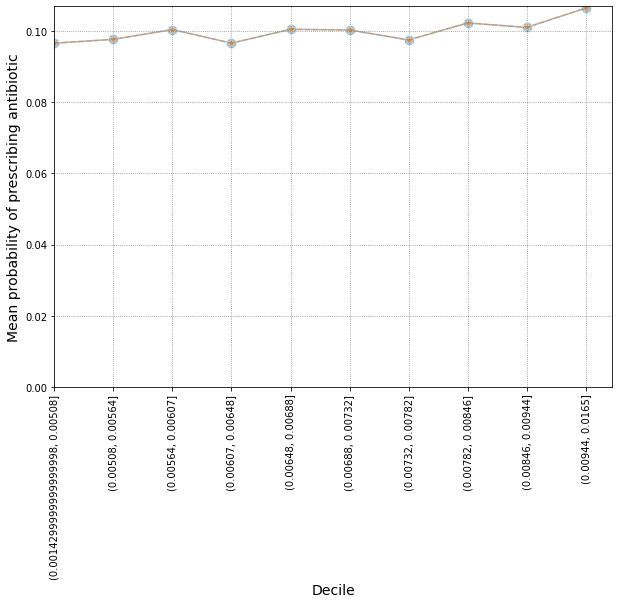


AUROC of LR for deciles with development and validation data: 0.51000 and 0.50390
AUROC of RF for deciles with development and validation data: 0.51000 and 0.50390
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0014299999999999998, 0.00508]  0.106705  0.100567  0.113219
bins_(0.00508, 0.00564]                0.108132  0.101935  0.114706
bins_(0.00564, 0.00607]                0.111666  0.105331  0.118382
bins_(0.00607, 0.00648]                0.103933  0.097895  0.110343
bins_(0.00648, 0.00688]                0.112273  0.105912  0.119016
bins_(0.00688, 0.00732]                0.110514  0.104255  0.117149
bins_(0.00732, 0.00782]                0.109158  0.102934  0.115759
bins_(0.00782, 0.00846]                0.112274  0.105937  0.118990
bins_(0.00846, 0.00944]                0.111417  0.105102  0.118112
bins_(0.00944, 0.0165]                 0.121003  0.114351  0.128041

RF feature importance:
                                         rf_c

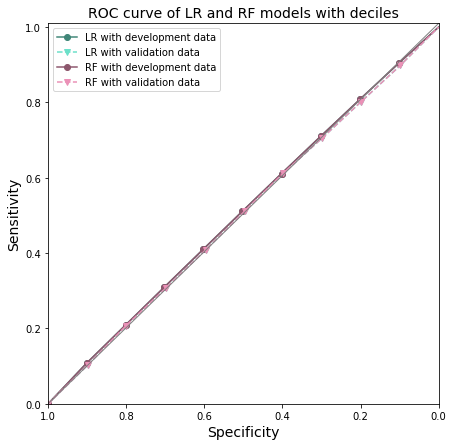

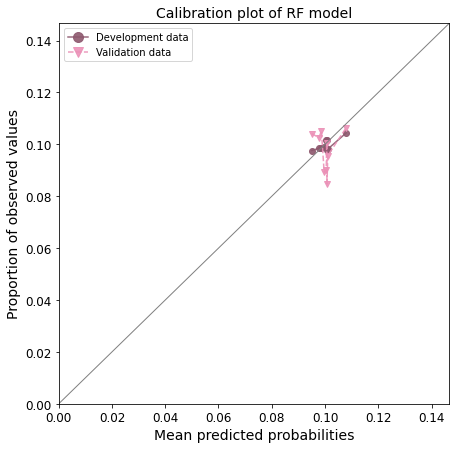

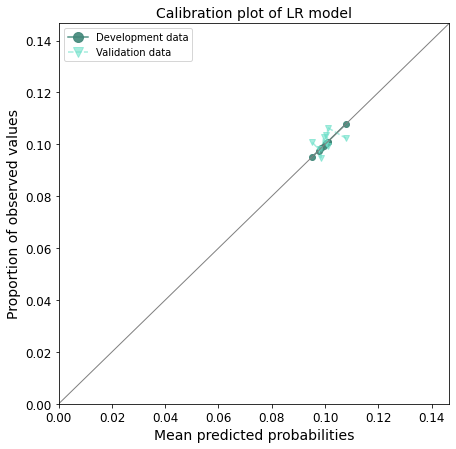


AUROC of LR for risk factors with development and validation data: 0.52154 and 0.50168
AUROC of RF for risk factors with development and validation data: 0.59458 and 0.50109
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.862378       NaN       NaN
age_cat_25_34                0.899368       NaN       NaN
age_cat_35_44                0.854175       NaN       NaN
age_cat_45_54                0.886816       NaN       NaN
age_cat_55_64                0.893343       NaN       NaN
age_cat_65_74                0.928077       NaN       NaN
age_cat_75_more              0.867828       NaN       NaN
sex_female                   0.655916       NaN       NaN
sex_male                     0.644470       NaN       NaN
CCI_cat_high                 0.868603       NaN       NaN
CCI_cat_low                  0.836169       NaN       NaN
CCI_cat_medium               0.841716       NaN       NaN
CCI_cat_very_high            0.856659       NaN      

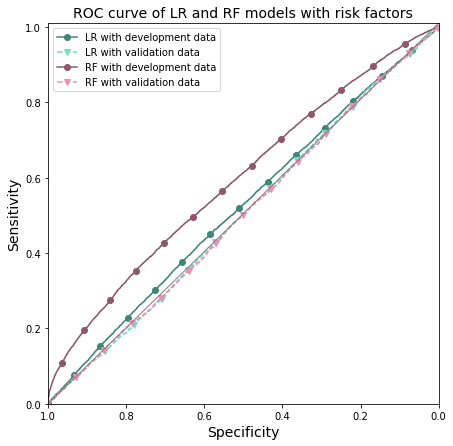

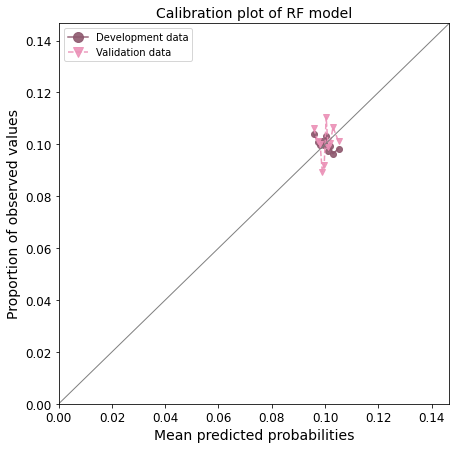

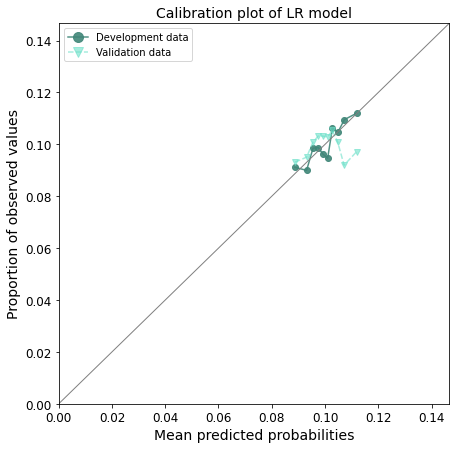

In [38]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt, prob_pred_uti_no_abs_incdt_bin = cox_build('uti', 'incdt', data_uti_incdt, data_uti_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('uti', 'incdt_deciles', prob_pred_uti_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('uti', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('uti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('uti', 'incdt_riskfactors', prob_pred_uti_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('uti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12467 total observations, 12388 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 12467
number of events observed = 79
   partial log-likelihood = -723.87
         time fit was run = 2023-06-29 21:11:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.58       0.56       0.31            -1.20             0.04                 0.30                 1.04
CCI_cat[T.medium]               -0.42       0.66       0.35            -1.09             0.26                 0.33                 1.30
CCI_cat[T.high]                 -0.12       0.89       0.39            -0.89             0.65                 0.41                 1.92
CCI_cat[T.very_high]            -0.36       0.70       0.36            -1.07             0.35                 0.34                 1.42
age_cat[T.25_34]                -0.10       0.91       0.44            -0.95             0.76                 0.38                 2.14
age_cat[T.35_44]                -0.47       0.62       0.48            -1.42             0.48                 0.24                 1.61
age_cat[T.45_54]                 0.05       1.05       0.42            -0.77             0.87                 0.46                 2.39
age_cat[T.55_64]                 0.01       1.01       0.43            -0.83             0.85                 0.44                 2.33
age_cat[T.65_74]                 0.07       1.07       0.42            -0.75             0.89                 0.47                 2.43
age_cat[T.75_more]               0.33       1.39       0.39            -0.44             1.10                 0.65                 3.01
antibacterial_brit               0.02       1.02       0.08            -0.13             0.18                 0.88                 1.19
bmi_cat[T.obese]                 0.09       1.09       0.44            -0.77             0.94                 0.46                 2.57
bmi_cat[T.overweight]           -0.77       0.46       0.65            -2.04             0.50                 0.13                 1.64
bmi_cat[T.underweight]          -0.27       0.77       0.82            -1.87             1.34                 0.15                 3.80
bmi_cat[T.unknown]               0.17       1.18       0.46            -0.73             1.07                 0.48                 2.91
ethnicity[T.other]              -1.13       0.32       0.67            -2.44             0.17                 0.09                 1.19
ethnicity[T.unknown]            -0.10       0.90       0.39            -0.86             0.66                 0.42                 1.93
ethnicity[T.white]              -0.59       0.55       0.37            -1.32             0.13                 0.27                 1.14
flu_vaccine[T.yes]              -0.02       0.98       0.37            -0.76             0.71                 0.47                 2.03
imd[T.medium]                    0.55       1.73       0.37            -0.17             1.27                 0.85                 3.55
imd[T.unaffluent]               -0.01       0.99       0.41            -0.81             0.79                 0.44                 2.20
imd[T.unknown]                   0.40       1.50       0.53            -0.64             1.45                 0.53                 4.26
imd[T.very_affluent]             0.14       1.15       0.39            -0.63             0.91                 0.53                 2.49
imd[T.very_unaffluent]           0.33       1.39       0.38            -0.42             1.08                 0.66                 2.93
region[T.east_midlands]          0.73       2.07       0.50            -

12211


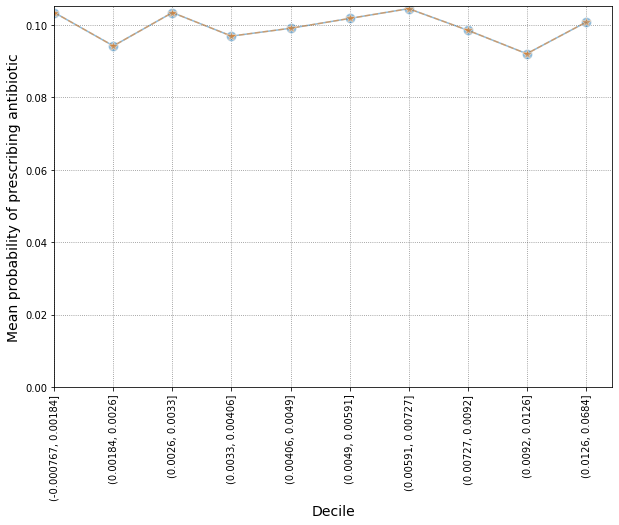


AUROC of LR for deciles with development and validation data: 0.51451 and 0.49018
AUROC of RF for deciles with development and validation data: 0.51434 and 0.49093
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000767, 0.00184]  0.108260  0.090645  0.129298
bins_(0.00184, 0.0026]     0.100000  0.083266  0.120097
bins_(0.0026, 0.0033]      0.114952  0.096684  0.136671
bins_(0.0033, 0.00406]     0.108713  0.091081  0.129759
bins_(0.00406, 0.0049]     0.101286  0.084328  0.121655
bins_(0.0049, 0.00591]     0.115385  0.097103  0.137108
bins_(0.00591, 0.00727]    0.111376  0.093530  0.132627
bins_(0.00727, 0.0092]     0.114650  0.096490  0.136227
bins_(0.0092, 0.0126]      0.100719  0.083860  0.120968
bins_(0.0126, 0.0684]      0.108678  0.090932  0.129887

RF feature importance:
                             rf_coef
bins_(0.00184, 0.0026]     0.122313
bins_(0.0026, 0.0033]      0.115414
bins_(0.0092, 0.0126]      0.112419
bins_(0.0049, 0.00591]     0.109

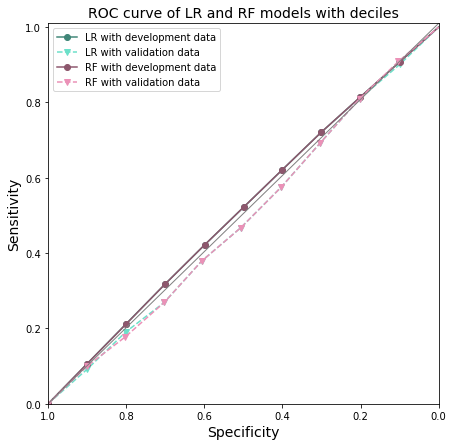

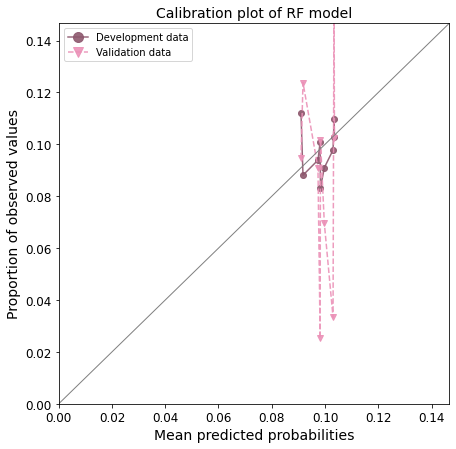

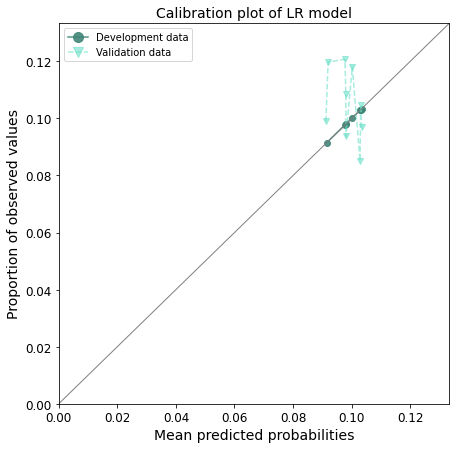


AUROC of LR for risk factors with development and validation data: 0.55466 and 0.49237
AUROC of RF for risk factors with development and validation data: 0.77572 and 0.50339
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.882565  0.000000       inf
age_cat_25_34                0.888891  0.000000       inf
age_cat_35_44                0.880849  0.000000       inf
age_cat_45_54                0.886845  0.000000       inf
age_cat_55_64                0.874903  0.000000       inf
age_cat_65_74                0.817057  0.000000       inf
age_cat_75_more              0.955013  0.000000       inf
sex_female                   0.622858       NaN       NaN
sex_male                     0.671704       NaN       NaN
CCI_cat_high                 0.745453       NaN       NaN
CCI_cat_low                  0.805999       NaN       NaN
CCI_cat_medium               0.909514       NaN       NaN
CCI_cat_very_high            0.852037       NaN      

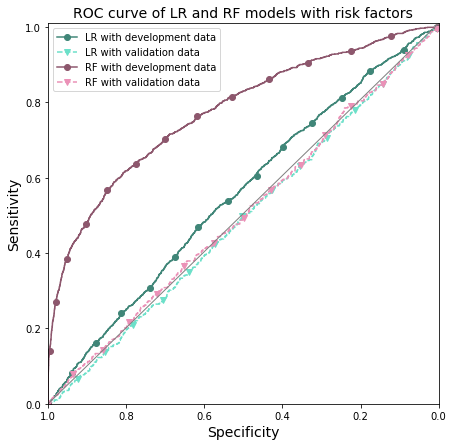

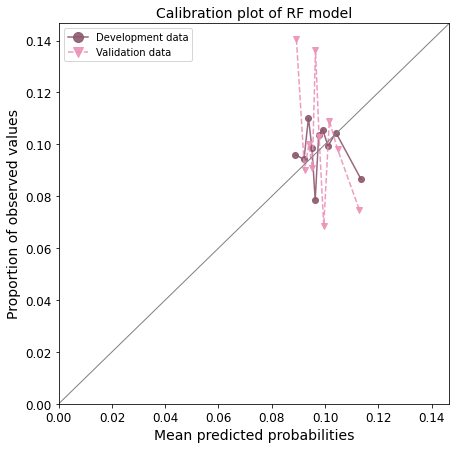

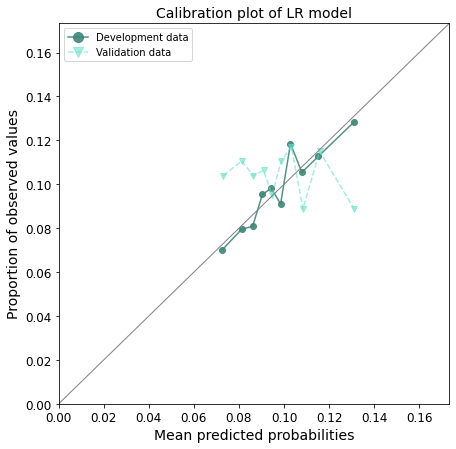

In [39]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl, prob_pred_uti_no_abs_prevl_bin = cox_build('uti', 'prevl', data_uti_prevl, data_uti_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('uti', 'prevl_deciles', prob_pred_uti_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('uti', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('uti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('uti', 'prevl_riskfactors', prob_pred_uti_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('uti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 31173 total observations, 30978 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 31173
number of events observed = 195
   partial log-likelihood = -2002.87
         time fit was run = 2023-06-29 21:11:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.22            -0.54             0.30                 0.58                 1.36
CCI_cat[T.medium]                0.06       1.06       0.23            -0.40             0.51                 0.67                 1.66
CCI_cat[T.high]                 -0.11       0.89       0.29            -0.69             0.46                 0.50                 1.59
CCI_cat[T.very_high]             0.11       1.12       0.24            -0.36             0.58                 0.70                 1.78
age_cat[T.25_34]                -0.16       0.85       0.27            -0.69             0.37                 0.50                 1.44
age_cat[T.35_44]                 0.07       1.07       0.25            -0.43             0.57                 0.65                 1.77
age_cat[T.45_54]                -0.21       0.81       0.27            -0.75             0.32                 0.47                 1.38
age_cat[T.55_64]                -0.16       0.85       0.27            -0.68             0.37                 0.50                 1.44
age_cat[T.65_74]                 0.11       1.11       0.25            -0.39             0.60                 0.68                 1.82
age_cat[T.75_more]              -0.20       0.82       0.27            -0.73             0.34                 0.48                 1.41
antibacterial_brit              -0.03       0.97       0.05            -0.13             0.07                 0.88                 1.07
bmi_cat[T.obese]                -0.13       0.88       0.26            -0.63             0.38                 0.53                 1.46
bmi_cat[T.overweight]           -0.04       0.96       0.31            -0.65             0.57                 0.52                 1.78
bmi_cat[T.underweight]          -0.32       0.73       0.51            -1.31             0.67                 0.27                 1.96
bmi_cat[T.unknown]              -0.11       0.90       0.28            -0.65             0.43                 0.52                 1.54
ethnicity[T.other]               0.63       1.87       0.41            -0.18             1.44                 0.83                 4.20
ethnicity[T.unknown]             0.67       1.96       0.36            -0.03             1.38                 0.97                 3.96
ethnicity[T.white]               0.43       1.54       0.35            -0.25             1.11                 0.78                 3.04
flu_vaccine[T.yes]               0.02       1.02       0.24            -0.45             0.48                 0.64                 1.61
imd[T.medium]                    0.11       1.12       0.25            -0.38             0.60                 0.69                 1.82
imd[T.unaffluent]                0.06       1.06       0.25            -0.43             0.55                 0.65                 1.74
imd[T.unknown]                   0.55       1.72       0.32            -0.09             1.18                 0.92                 3.24
imd[T.very_affluent]             0.50       1.65       0.23             0.05             0.95                 1.05                 2.59
imd[T.very_unaffluent]           0.10       1.10       0.25            -0.39             0.58                 0.68                 1.79
region[T.east_midlands]         -0.06       0.94       0.33           

12208


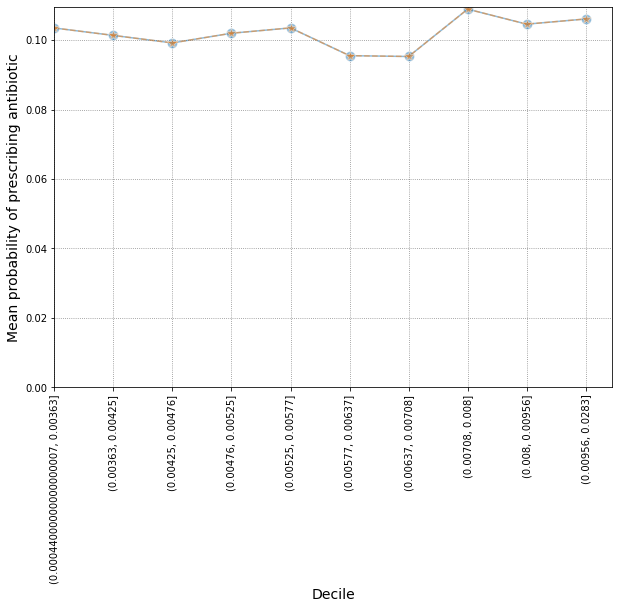


AUROC of LR for deciles with development and validation data: 0.51686 and 0.49824
AUROC of RF for deciles with development and validation data: 0.51683 and 0.49670
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(0.00044000000000000007, 0.00363]  0.111757  0.100006  0.124889
bins_(0.00363, 0.00425]                 0.113057  0.101306  0.126171
bins_(0.00425, 0.00476]                 0.108542  0.097018  0.121435
bins_(0.00476, 0.00525]                 0.116181  0.104153  0.129598
bins_(0.00525, 0.00577]                 0.118075  0.106061  0.131450
bins_(0.00577, 0.00637]                 0.108185  0.096748  0.120974
bins_(0.00637, 0.00708]                 0.100765  0.089758  0.113123
bins_(0.00708, 0.008]                   0.125367  0.112747  0.139401
bins_(0.008, 0.00956]                   0.118214  0.106108  0.131701
bins_(0.00956, 0.0283]                  0.121526  0.109189  0.135256

RF feature importance:
                                  

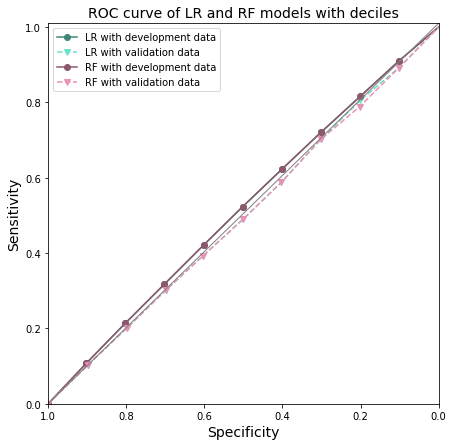

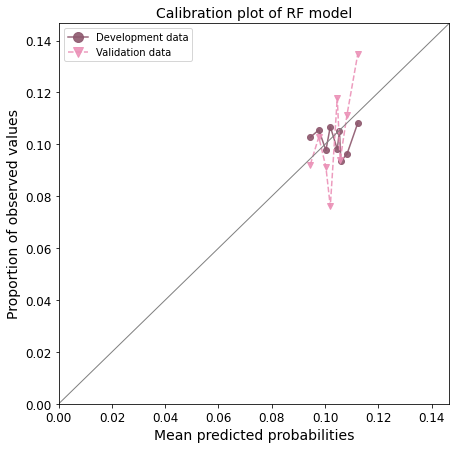

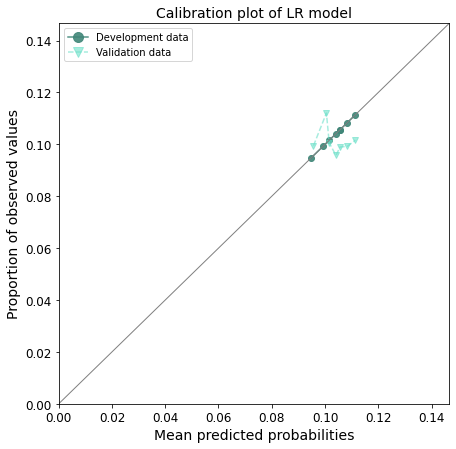

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_prepandemic, prob_pred_uti_no_abs_incdt_prepandemic_bin = cox_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic, data_uti_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('uti', 'incdt_prepandemic', prob_pred_uti_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 35571 total observations, 35345 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 35571
number of events observed = 226
   partial log-likelihood = -2350.18
         time fit was run = 2023-06-29 21:11:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.19            -0.47             0.28                 0.63                 1.32
CCI_cat[T.medium]               -0.02       0.98       0.21            -0.43             0.39                 0.65                 1.47
CCI_cat[T.high]                 -0.25       0.78       0.27            -0.78             0.27                 0.46                 1.31
CCI_cat[T.very_high]            -0.34       0.71       0.24            -0.81             0.13                 0.45                 1.14
age_cat[T.25_34]                -0.10       0.91       0.24            -0.56             0.36                 0.57                 1.44
age_cat[T.35_44]                -0.21       0.81       0.24            -0.68             0.27                 0.50                 1.30
age_cat[T.45_54]                -0.11       0.90       0.24            -0.58             0.36                 0.56                 1.43
age_cat[T.55_64]                -0.26       0.77       0.25            -0.75             0.23                 0.47                 1.26
age_cat[T.65_74]                -0.08       0.93       0.23            -0.54             0.38                 0.58                 1.47
age_cat[T.75_more]              -0.34       0.71       0.25            -0.83             0.15                 0.43                 1.16
antibacterial_brit              -0.09       0.91       0.05            -0.19             0.00                 0.83                 1.00
bmi_cat[T.obese]                 0.47       1.60       0.30            -0.12             1.06                 0.88                 2.89
bmi_cat[T.overweight]            0.49       1.64       0.35            -0.18             1.17                 0.83                 3.22
bmi_cat[T.underweight]          -0.04       0.97       0.53            -1.08             1.01                 0.34                 2.74
bmi_cat[T.unknown]               0.30       1.36       0.32            -0.32             0.93                 0.73                 2.54
ethnicity[T.other]              -0.13       0.87       0.34            -0.81             0.54                 0.45                 1.71
ethnicity[T.unknown]            -0.15       0.86       0.27            -0.68             0.39                 0.51                 1.48
ethnicity[T.white]              -0.05       0.95       0.25            -0.55             0.44                 0.58                 1.55
flu_vaccine[T.yes]               0.20       1.23       0.21            -0.20             0.61                 0.82                 1.83
imd[T.medium]                   -0.01       0.99       0.20            -0.41             0.39                 0.66                 1.47
imd[T.unaffluent]               -0.30       0.74       0.22            -0.73             0.13                 0.48                 1.14
imd[T.unknown]                  -0.08       0.92       0.32            -0.71             0.55                 0.49                 1.73
imd[T.very_affluent]            -0.26       0.77       0.22            -0.68             0.17                 0.51                 1.18
imd[T.very_unaffluent]          -0.15       0.86       0.21            -0.56             0.26                 0.57                 1.30
region[T.east_midlands]          0.21       1.23       0.31           

12226


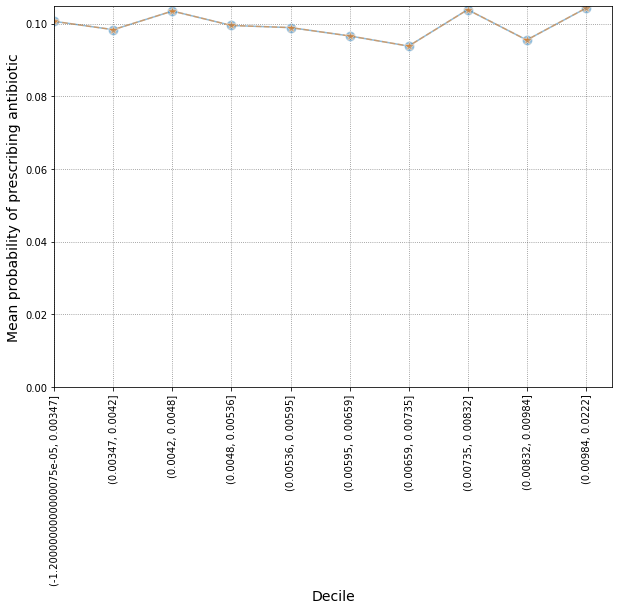


AUROC of LR for deciles with development and validation data: 0.51060 and 0.50394
AUROC of RF for deciles with development and validation data: 0.51060 and 0.50394
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-1.2000000000000075e-05, 0.00347]  0.115889  0.104690  0.128287
bins_(0.00347, 0.0042]                   0.110955  0.100015  0.123093
bins_(0.0042, 0.0048]                    0.119284  0.107806  0.131985
bins_(0.0048, 0.00536]                   0.108538  0.097756  0.120509
bins_(0.00536, 0.00595]                  0.107918  0.097121  0.119915
bins_(0.00595, 0.00659]                  0.110355  0.099383  0.122537
bins_(0.00659, 0.00735]                  0.107405  0.096622  0.119392
bins_(0.00735, 0.00832]                  0.112719  0.101714  0.124915
bins_(0.00832, 0.00984]                  0.104807  0.094230  0.116572
bins_(0.00984, 0.0222]                   0.114563  0.103329  0.127017

RF feature importance:
                       

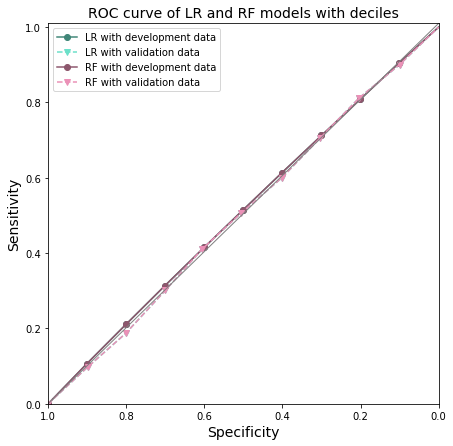

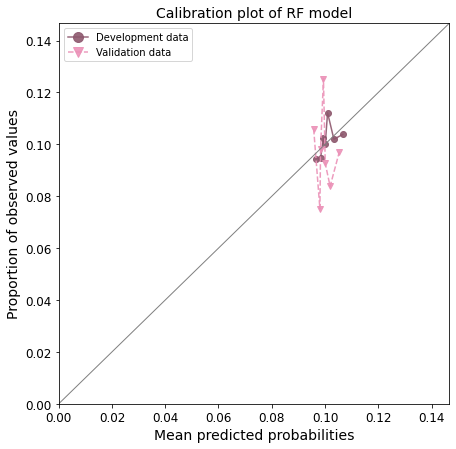

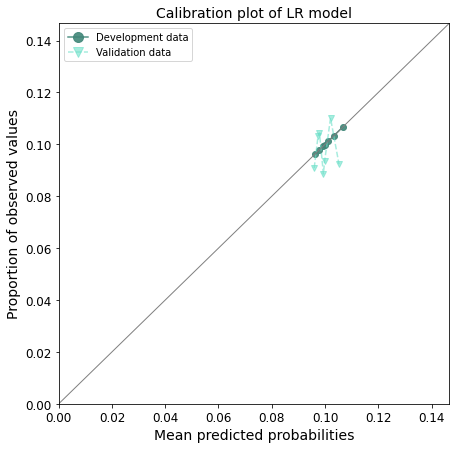

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_during_pandemic, prob_pred_uti_no_abs_incdt_during_pandemic_bin = cox_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic, data_uti_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('uti', 'incdt_during_pandemic', prob_pred_uti_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 45999 total observations, 45635 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 45999
number of events observed = 364
   partial log-likelihood = -3880.54
         time fit was run = 2023-06-29 21:12:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.16            -0.15             0.49                 0.86                 1.63
CCI_cat[T.medium]                0.15       1.16       0.18            -0.20             0.50                 0.82                 1.65
CCI_cat[T.high]                  0.08       1.08       0.22            -0.34             0.50                 0.71                 1.65
CCI_cat[T.very_high]             0.21       1.24       0.18            -0.15             0.57                 0.86                 1.77
age_cat[T.25_34]                 0.02       1.02       0.19            -0.35             0.39                 0.70                 1.47
age_cat[T.35_44]                -0.06       0.94       0.19            -0.43             0.31                 0.65                 1.37
age_cat[T.45_54]                -0.11       0.89       0.19            -0.50             0.27                 0.61                 1.31
age_cat[T.55_64]                -0.20       0.82       0.20            -0.59             0.19                 0.55                 1.21
age_cat[T.65_74]                -0.00       1.00       0.19            -0.37             0.37                 0.69                 1.45
age_cat[T.75_more]              -0.19       0.83       0.20            -0.57             0.20                 0.56                 1.22
antibacterial_brit               0.01       1.01       0.04            -0.06             0.09                 0.94                 1.09
bmi_cat[T.obese]                 0.12       1.13       0.20            -0.27             0.52                 0.76                 1.68
bmi_cat[T.overweight]            0.04       1.04       0.24            -0.44             0.51                 0.64                 1.67
bmi_cat[T.underweight]           0.20       1.23       0.33            -0.44             0.85                 0.65                 2.33
bmi_cat[T.unknown]              -0.26       0.77       0.22            -0.70             0.17                 0.50                 1.19
ethnicity[T.other]              -0.30       0.74       0.27            -0.84             0.24                 0.43                 1.27
ethnicity[T.unknown]            -0.26       0.77       0.21            -0.67             0.15                 0.51                 1.16
ethnicity[T.white]              -0.11       0.89       0.19            -0.48             0.26                 0.62                 1.29
flu_vaccine[T.yes]              -0.12       0.89       0.18            -0.48             0.24                 0.62                 1.27
imd[T.medium]                   -0.00       1.00       0.17            -0.34             0.33                 0.71                 1.39
imd[T.unaffluent]                0.10       1.10       0.16            -0.22             0.42                 0.80                 1.52
imd[T.unknown]                  -0.07       0.94       0.27            -0.60             0.46                 0.55                 1.59
imd[T.very_affluent]            -0.03       0.97       0.17            -0.36             0.30                 0.69                 1.35
imd[T.very_unaffluent]          -0.11       0.89       0.17            -0.45             0.23                 0.63                 1.25
region[T.east_midlands]         -0.23       0.80       0.20           

12250


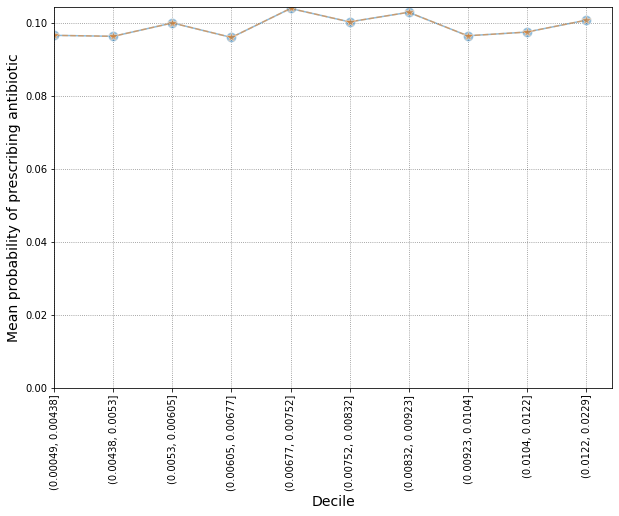


AUROC of LR for deciles with development and validation data: 0.50881 and 0.50282
AUROC of RF for deciles with development and validation data: 0.50881 and 0.50282
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00049, 0.00438]  0.109004  0.099392  0.119544
bins_(0.00438, 0.0053]   0.106434  0.096950  0.116845
bins_(0.0053, 0.00605]   0.110819  0.101086  0.121488
bins_(0.00605, 0.00677]  0.107643  0.098157  0.118045
bins_(0.00677, 0.00752]  0.115810  0.105886  0.126665
bins_(0.00752, 0.00832]  0.112618  0.102812  0.123359
bins_(0.00832, 0.00923]  0.116071  0.106114  0.126963
bins_(0.00923, 0.0104]   0.108333  0.098729  0.118872
bins_(0.0104, 0.0122]    0.115033  0.105125  0.125874
bins_(0.0122, 0.0229]    0.114836  0.104972  0.125626

RF feature importance:
                           rf_coef
bins_(0.00438, 0.0053]   0.126474
bins_(0.00832, 0.00923]  0.122102
bins_(0.00677, 0.00752]  0.119945
bins_(0.0122, 0.0229]    0.112120
bins_(0.00605, 0.00677]  0.1

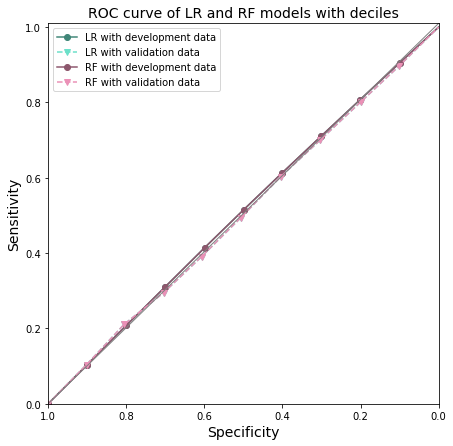

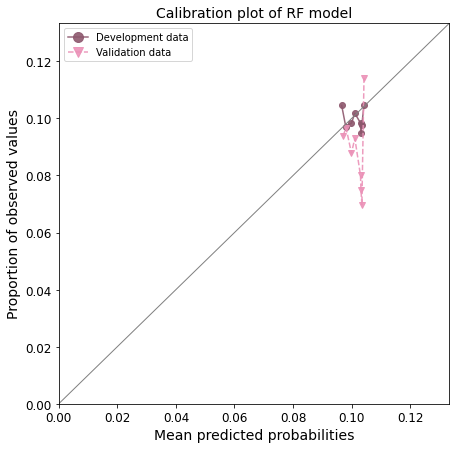

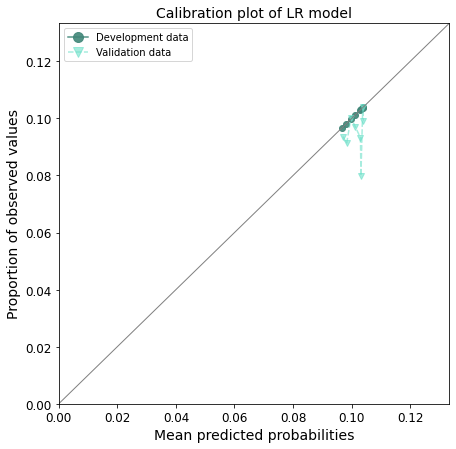

In [42]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_post_2nd_lockdown, prob_pred_uti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown, data_uti_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('uti', 'incdt_post_2nd_lockdown', prob_pred_uti_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3342 total observations, 3325 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3342
number of events observed = 17
   partial log-likelihood = -117.09
         time fit was run = 2023-06-29 21:12:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.88            -1.72             1.75                 0.18                 5.76
CCI_cat[T.medium]               -0.81       0.44       1.24            -3.24             1.62                 0.04                 5.07
CCI_cat[T.high]                  1.47       4.36       0.89            -0.27             3.21                 0.76                24.86
CCI_cat[T.very_high]             1.31       3.70       0.84            -0.33             2.95                 0.72                19.13
age_cat[T.25_34]                -0.07       0.94       0.95            -1.94             1.80                 0.14                 6.06
age_cat[T.35_44]                -0.03       0.97       0.95            -1.88             1.83                 0.15                 6.21
age_cat[T.45_54]                 0.21       1.24       0.84            -1.44             1.87                 0.24                 6.46
age_cat[T.55_64]                -0.20       0.82       0.94            -2.04             1.63                 0.13                 5.12
age_cat[T.65_74]                -0.76       0.47       1.19            -3.09             1.57                 0.05                 4.83
age_cat[T.75_more]               0.60       1.83       0.81            -0.99             2.19                 0.37                 8.94
antibacterial_brit               0.09       1.09       0.18            -0.26             0.43                 0.77                 1.54
bmi_cat[T.obese]                -1.21       0.30       0.72            -2.62             0.19                 0.07                 1.22
bmi_cat[T.overweight]           -1.47       0.23       1.17            -3.77             0.83                 0.02                 2.30
bmi_cat[T.underweight]         -17.85       0.00    3602.63         -7078.87          7043.17                 0.00                  inf
bmi_cat[T.unknown]              -0.82       0.44       0.74            -2.26             0.63                 0.10                 1.88
ethnicity[T.other]             -18.64       0.00    5404.52        -10611.31         10574.03                 0.00                  inf
ethnicity[T.unknown]            -1.38       0.25       0.75            -2.84             0.09                 0.06                 1.09
ethnicity[T.white]              -1.54       0.21       0.65            -2.80            -0.27                 0.06                 0.76
flu_vaccine[T.yes]               0.19       1.21       0.78            -1.35             1.72                 0.26                 5.60
imd[T.medium]                    1.22       3.40       1.14            -1.01             3.45                 0.37                31.64
imd[T.unaffluent]                1.13       3.09       1.17            -1.16             3.42                 0.31                30.46
imd[T.unknown]                   2.76      15.78       1.15             0.50             5.01                 1.65               150.63
imd[T.very_affluent]             1.01       2.74       1.17            -1.29             3.31                 0.28                27.26
imd[T.very_unaffluent]           0.57       1.78       1.24            -1.86             3.00                 0.16                20.17
region[T.east_midlands]         16.42   1.35e+07    3402.00         -6651.3

12333


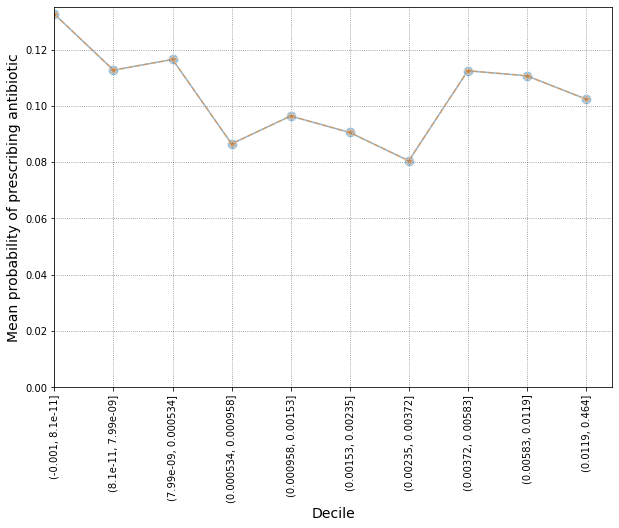


AUROC of LR for deciles with development and validation data: 0.56361 and 0.46848
AUROC of RF for deciles with development and validation data: 0.56352 and 0.46274
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 8.1e-11]     0.170279  0.127937  0.226634
bins_(0.000534, 0.000958]  0.102102  0.071744  0.145307
bins_(0.000958, 0.00153]   0.104294  0.073258  0.148479
bins_(0.00153, 0.00235]    0.069971  0.046258  0.105839
bins_(0.00235, 0.00372]    0.101744  0.071860  0.144056
bins_(0.00372, 0.00583]    0.141975  0.104255  0.193343
bins_(0.00583, 0.0119]     0.151515  0.112533  0.204001
bins_(0.0119, 0.464]       0.121739  0.088373  0.167702
bins_(7.99e-09, 0.000534]  0.122754  0.088752  0.169784
bins_(8.1e-11, 7.99e-09]   0.108434  0.076878  0.152941

RF feature importance:
                             rf_coef
bins_(0.00153, 0.00235]    0.238917
bins_(-0.001, 8.1e-11]     0.211549
bins_(0.00583, 0.0119]     0.136979
bins_(0.00372, 0.00583]    0.094

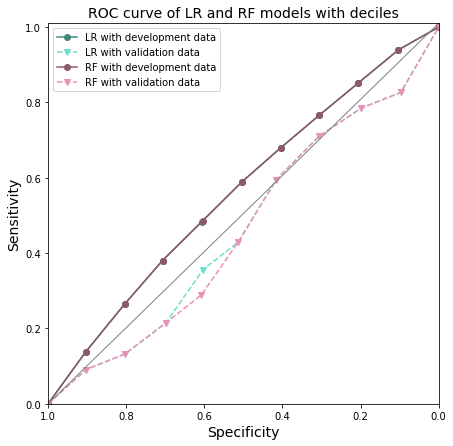

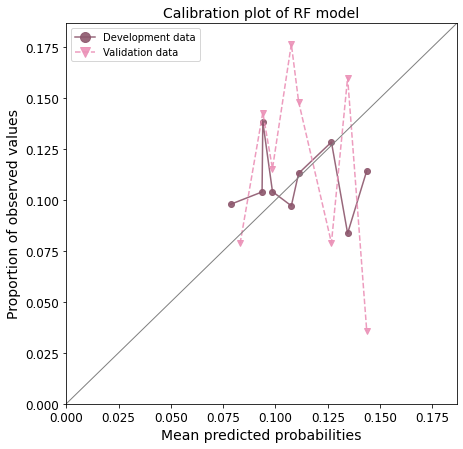

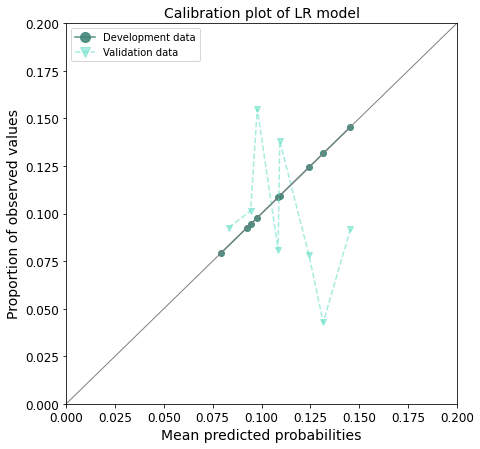

In [43]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_prepandemic, prob_pred_uti_no_abs_prevl_prepandemic_bin = cox_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic, data_uti_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('uti', 'prevl_prepandemic', prob_pred_uti_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3975 total observations, 3946 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3975
number of events observed = 29
   partial log-likelihood = -227.25
         time fit was run = 2023-06-29 21:12:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.39       0.68       0.50            -1.37             0.59                 0.26                 1.81
CCI_cat[T.medium]               -0.52       0.60       0.59            -1.67             0.64                 0.19                 1.90
CCI_cat[T.high]                 -0.36       0.70       0.70            -1.72             1.00                 0.18                 2.73
CCI_cat[T.very_high]            -0.57       0.57       0.63            -1.81             0.67                 0.16                 1.96
age_cat[T.25_34]                 0.31       1.36       0.59            -0.86             1.47                 0.42                 4.36
age_cat[T.35_44]                -1.66       0.19       1.10            -3.81             0.50                 0.02                 1.65
age_cat[T.45_54]                -0.55       0.58       0.74            -1.99             0.89                 0.14                 2.44
age_cat[T.55_64]                -0.46       0.63       0.74            -1.91             0.98                 0.15                 2.66
age_cat[T.65_74]                 0.16       1.17       0.61            -1.04             1.36                 0.35                 3.91
age_cat[T.75_more]              -0.31       0.73       0.68            -1.64             1.01                 0.19                 2.76
antibacterial_brit               0.10       1.11       0.13            -0.15             0.35                 0.86                 1.42
bmi_cat[T.obese]                 0.94       2.57       1.03            -1.08             2.97                 0.34                19.47
bmi_cat[T.overweight]            0.71       2.03       1.16            -1.57             2.98                 0.21                19.72
bmi_cat[T.underweight]           0.77       2.15       1.42            -2.02             3.55                 0.13                34.95
bmi_cat[T.unknown]               0.55       1.74       1.09            -1.58             2.68                 0.21                14.63
ethnicity[T.other]               0.11       1.12       0.82            -1.51             1.73                 0.22                 5.62
ethnicity[T.unknown]             0.25       1.28       0.66            -1.04             1.54                 0.35                 4.65
ethnicity[T.white]              -0.58       0.56       0.65            -1.86             0.69                 0.16                 2.00
flu_vaccine[T.yes]              -0.36       0.70       0.74            -1.81             1.09                 0.16                 2.97
imd[T.medium]                    0.49       1.62       0.65            -0.79             1.76                 0.45                 5.84
imd[T.unaffluent]                0.18       1.20       0.68            -1.15             1.50                 0.32                 4.50
imd[T.unknown]                  -0.18       0.83       1.13            -2.39             2.02                 0.09                 7.55
imd[T.very_affluent]             0.36       1.44       0.65            -0.91             1.64                 0.40                 5.14
imd[T.very_unaffluent]           0.55       1.74       0.63            -0.68             1.79                 0.50                 6.00
region[T.east_midlands]          0.73       2.07       0.71            -0.6

12219


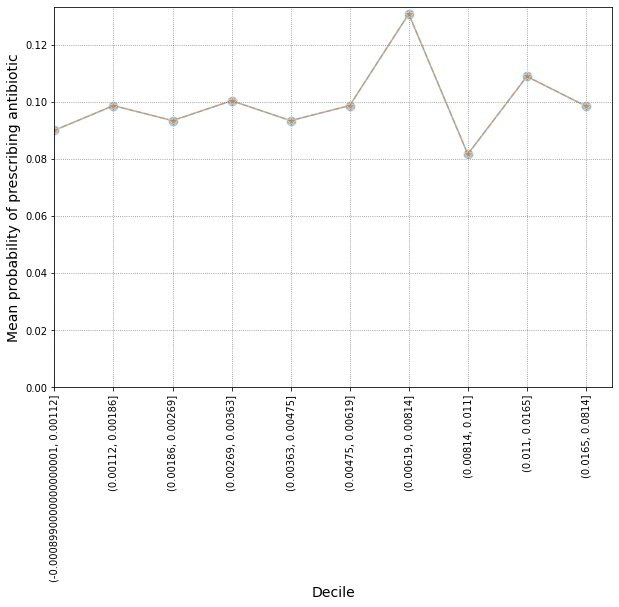


AUROC of LR for deciles with development and validation data: 0.54693 and 0.49878
AUROC of RF for deciles with development and validation data: 0.54690 and 0.49685
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(-0.0008990000000000001, 0.00112]  0.089744  0.063505  0.126824
bins_(0.00112, 0.00186]                 0.116337  0.086007  0.157362
bins_(0.00186, 0.00269]                 0.093976  0.067679  0.130490
bins_(0.00269, 0.00363]                 0.096203  0.068963  0.134202
bins_(0.00363, 0.00475]                 0.105911  0.077345  0.145028
bins_(0.00475, 0.00619]                 0.106173  0.077533  0.145391
bins_(0.00619, 0.00814]                 0.144703  0.109340  0.191503
bins_(0.00814, 0.011]                   0.076923  0.053383  0.110843
bins_(0.011, 0.0165]                    0.123077  0.091196  0.166103
bins_(0.0165, 0.0814]                   0.097744  0.070353  0.135800

RF feature importance:
                                  

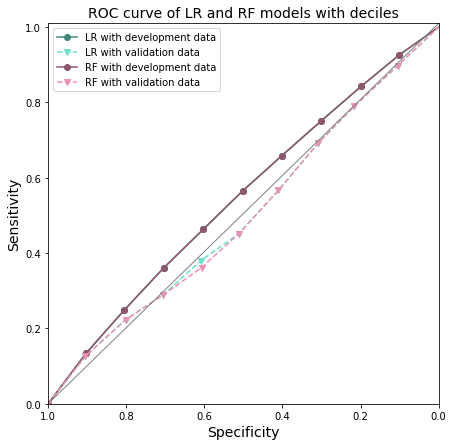

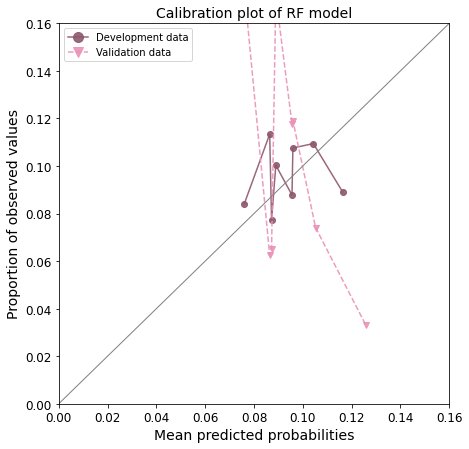

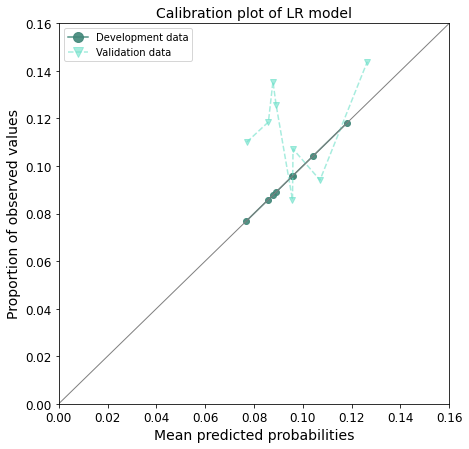

In [44]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_during_pandemic, prob_pred_uti_no_abs_prevl_during_pandemic_bin = cox_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic, data_uti_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('uti', 'prevl_during_pandemic', prob_pred_uti_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5149 total observations, 5112 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5149
number of events observed = 37
   partial log-likelihood = -294.97
         time fit was run = 2023-06-29 21:12:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.53            -0.74             1.33                 0.47                 3.79
CCI_cat[T.medium]                0.22       1.24       0.59            -0.94             1.37                 0.39                 3.93
CCI_cat[T.high]                  0.10       1.10       0.73            -1.34             1.54                 0.26                 4.65
CCI_cat[T.very_high]             0.61       1.84       0.56            -0.49             1.71                 0.61                 5.52
age_cat[T.25_34]                -0.04       0.96       0.71            -1.43             1.36                 0.24                 3.88
age_cat[T.35_44]                 0.37       1.44       0.68            -0.96             1.69                 0.38                 5.43
age_cat[T.45_54]                 0.45       1.57       0.65            -0.82             1.72                 0.44                 5.60
age_cat[T.55_64]                 0.26       1.29       0.67            -1.06             1.58                 0.35                 4.84
age_cat[T.65_74]                 0.23       1.25       0.67            -1.10             1.55                 0.33                 4.70
age_cat[T.75_more]               0.65       1.92       0.62            -0.56             1.86                 0.57                 6.45
antibacterial_brit              -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
bmi_cat[T.obese]                -0.38       0.69       0.55            -1.46             0.71                 0.23                 2.03
bmi_cat[T.overweight]           -1.86       0.16       1.12            -4.06             0.34                 0.02                 1.40
bmi_cat[T.underweight]          -0.75       0.47       1.12            -2.95             1.45                 0.05                 4.28
bmi_cat[T.unknown]              -0.12       0.89       0.58            -1.26             1.02                 0.28                 2.78
ethnicity[T.other]              -1.51       0.22       1.10            -3.67             0.64                 0.03                 1.90
ethnicity[T.unknown]            -0.44       0.64       0.55            -1.51             0.63                 0.22                 1.87
ethnicity[T.white]              -0.75       0.47       0.51            -1.74             0.25                 0.18                 1.28
flu_vaccine[T.yes]              -0.36       0.70       0.61            -1.55             0.83                 0.21                 2.29
imd[T.medium]                    1.08       2.94       0.52             0.06             2.10                 1.06                 8.14
imd[T.unaffluent]                0.25       1.28       0.61            -0.95             1.44                 0.39                 4.21
imd[T.unknown]                  -0.16       0.85       1.10            -2.32             2.00                 0.10                 7.37
imd[T.very_affluent]             0.15       1.17       0.61            -1.04             1.34                 0.35                 3.84
imd[T.very_unaffluent]          -0.16       0.85       0.67            -1.48             1.16                 0.23                 3.19
region[T.east_midlands]          0.98       2.66       0.82            -0.6

12212


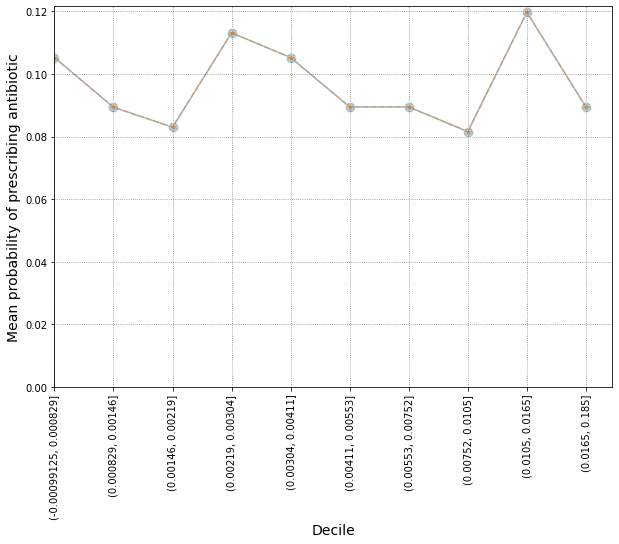


AUROC of LR for deciles with development and validation data: 0.55075 and 0.49871
AUROC of RF for deciles with development and validation data: 0.55075 and 0.49871
LR coefficients:
                                     OR  Lower CI  Upper CI
bins_(-0.00099125, 0.000829]  0.122772  0.094309  0.159826
bins_(0.000829, 0.00146]      0.099391  0.074105  0.133306
bins_(0.00146, 0.00219]       0.081749  0.059907  0.111556
bins_(0.00219, 0.00304]       0.130522  0.100792  0.169021
bins_(0.00304, 0.00411]       0.120792  0.092610  0.157550
bins_(0.00411, 0.00553]       0.087891  0.064803  0.119204
bins_(0.00553, 0.00752]       0.100952  0.076109  0.133905
bins_(0.00752, 0.0105]        0.089888  0.066902  0.120771
bins_(0.0105, 0.0165]         0.144250  0.113049  0.184061
bins_(0.0165, 0.185]          0.098881  0.074567  0.131122

RF feature importance:
                                rf_coef
bins_(0.0105, 0.0165]         0.253821
bins_(0.00219, 0.00304]       0.137918
bins_(0.00146, 0.00219]   

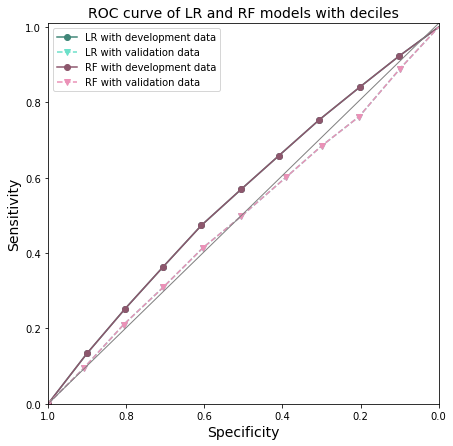

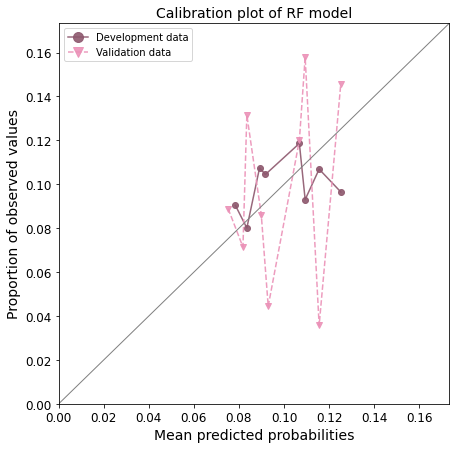

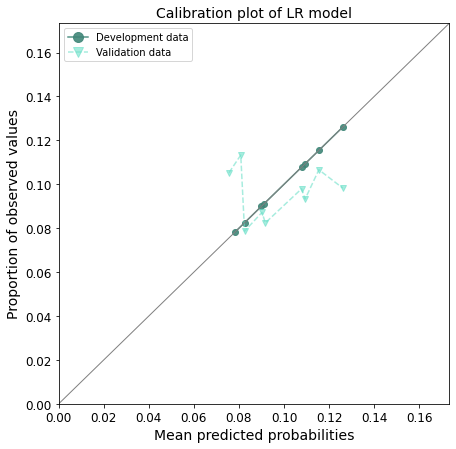

In [45]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_post_2nd_lockdown, prob_pred_uti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown, data_uti_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('uti', 'prevl_post_2nd_lockdown', prob_pred_uti_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)